<a href="https://colab.research.google.com/github/AdolfoBG21/Adolfo-Bautista/blob/main/Carpeta-CNN/ExpoCNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import tensorflow as tf
import tensorflow_datasets as tfds
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GlobalAveragePooling2D, Dropout, Dense
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import numpy as np

In [2]:
# Cargar el dataset de Oxford-IIIT Pet usando TensorFlow Datasets
(ds_train, ds_test), ds_info = tfds.load(
    'oxford_iiit_pet',
    split=['train', 'test'],
    with_info=True,
    as_supervised=True,  # Para obtener pares (imagen, etiqueta)
)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/2 [00:00<?, ? splits/s]

Generating train examples...: 0 examples [00:00, ? examples/s]

Shuffling /root/tensorflow_datasets/oxford_iiit_pet/incomplete.CQR3EA_4.0.0/oxford_iiit_pet-train.tfrecord*...…

Generating test examples...: 0 examples [00:00, ? examples/s]

Shuffling /root/tensorflow_datasets/oxford_iiit_pet/incomplete.CQR3EA_4.0.0/oxford_iiit_pet-test.tfrecord*...:…

Dataset oxford_iiit_pet downloaded and prepared to /root/tensorflow_datasets/oxford_iiit_pet/4.0.0. Subsequent calls will reuse this data.


In [3]:
#  Definición de Parámetros
# El dataset Oxford-IIIT Pet tiene 37 clases.
NUM_CLASSES = 37
IMG_SIZE = 224
BATCH_SIZE = 32

In [4]:
# Mostrar los nombres de las clases (índice) del dataset
if 'label' in ds_info.features:
    print("Índice del dataset (Nombres de las razas):")
    for i, name in enumerate(ds_info.features['label'].names):
        print(f"Índice {i}: {name}")
else:
    print("No se encontró información de las clases en el dataset.")

Índice del dataset (Nombres de las razas):
Índice 0: Abyssinian
Índice 1: american_bulldog
Índice 2: american_pit_bull_terrier
Índice 3: basset_hound
Índice 4: beagle
Índice 5: Bengal
Índice 6: Birman
Índice 7: Bombay
Índice 8: boxer
Índice 9: British_Shorthair
Índice 10: chihuahua
Índice 11: Egyptian_Mau
Índice 12: english_cocker_spaniel
Índice 13: english_setter
Índice 14: german_shorthaired
Índice 15: great_pyrenees
Índice 16: havanese
Índice 17: japanese_chin
Índice 18: keeshond
Índice 19: leonberger
Índice 20: Maine_Coon
Índice 21: miniature_pinscher
Índice 22: newfoundland
Índice 23: Persian
Índice 24: pomeranian
Índice 25: pug
Índice 26: Ragdoll
Índice 27: Russian_Blue
Índice 28: saint_bernard
Índice 29: samoyed
Índice 30: scottish_terrier
Índice 31: shiba_inu
Índice 32: Siamese
Índice 33: Sphynx
Índice 34: staffordshire_bull_terrier
Índice 35: wheaten_terrier
Índice 36: yorkshire_terrier


In [5]:
# Cargar el modelo base preentrenado (MobileNetV2) sin la capa de clasificación superior
base_model = MobileNetV2(
    input_shape=(IMG_SIZE, IMG_SIZE, 3),
    include_top=False,  # Quitamos la capa de clasificación original
    weights='imagenet'  # Usamos pesos preentrenados en ImageNet
)

9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


In [6]:
# Definir las transformaciones originales (deben coincidir con las que usaste antes)
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Cargar el dataset (si no está ya en memoria)
train_dataset = datasets.OxfordIIITPet(root='./data', split='trainval', download=True, transform=transform)


100%|██████████| 792M/792M [00:55<00:00, 14.3MB/s]
100%|██████████| 19.2M/19.2M [00:03<00:00, 6.35MB/s]


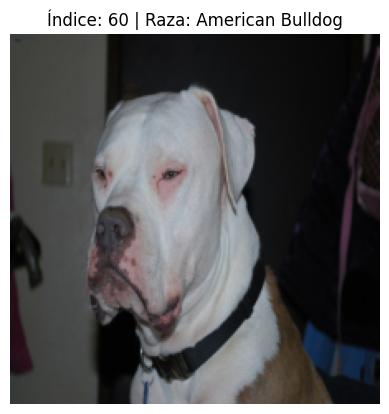

In [7]:
# Función para mostrar la imagen

def mostrar_imagen(dataset, indice):
    """Accede, invierte la normalización y muestra una imagen del dataset."""

    # 1. Obtener la imagen y la etiqueta (son tensores normalizados)
    imagen_tensor, indice_raza = dataset[indice]

    # 2. Invertir la normalización:
    # Definir la media y std originales (usadas para normalizar)
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])

    # Desnormalizar: imagen = imagen * std + mean
    imagen_np = imagen_tensor.numpy().transpose((1, 2, 0)) # Cambiar formato de (C, H, W) a (H, W, C) para Matplotlib
    imagen_np = std * imagen_np + mean

    # Asegurarse de que los valores de píxeles estén en el rango [0, 1]
    imagen_np = np.clip(imagen_np, 0, 1)

    # 3. Obtener el nombre de la raza
    nombre_raza = dataset.classes[indice_raza]

    # 4. Mostrar la imagen
    plt.imshow(imagen_np)
    plt.title(f"Índice: {indice} | Raza: {nombre_raza}")
    plt.axis('off')
    plt.show()

# Ejecutamos la función para ver una imagen
# Elige un índice.
indice_de_muestra = 60
mostrar_imagen(train_dataset, indice_de_muestra)

In [8]:
# Función de preprocesamiento: reescala y normaliza
def preprocess(image, label):
    # Redimensionar la imagen
    image = tf.image.resize(image, (IMG_SIZE, IMG_SIZE))
    # Normalizar los valores de píxeles al rango [0, 1] (necesario para MobileNetV2)
    image = image / 255.0
    # Convertir la etiqueta a índice (el dataset ya tiene 0-36)
    return image, label

In [9]:
# CÓDIGO NUEVO
from tensorflow.keras.layers import GlobalAveragePooling2D, Dropout, Dense

# 1. Congelar el modelo base (MobileNetV2 ya cargado)
# Esto asegura que los pesos pre-entrenados no se modifiquen
base_model.trainable = False

# 2. Definir el nuevo modelo con la cabeza de clasificación
model = Sequential([
    base_model,  # Usa MobileNetV2 como extractor de características
    GlobalAveragePooling2D(), # Capa que reduce la dimensionalidad
    Dropout(0.5), # Regularización: Apaga el 50% de las neuronas para evitar el overfitting
    Dense(NUM_CLASSES, activation='softmax') # Capa final de clasificación (37 razas)
])

In [10]:
learning_rate = 0.001
adam_optimizer = Adam(learning_rate=learning_rate)

In [ ]:
# Compilación y Entrenamiento ---
# Aplicar la función de preprocesamiento y batch a los datasets
ds_train = ds_train.map(preprocess).batch(BATCH_SIZE)
ds_test = ds_test.map(preprocess).batch(BATCH_SIZE)

model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(),
    metrics=['accuracy']
)
EPOCHS = 15
print("\nComenzando el entrenamiento...")
history = model.fit(
    ds_train,
    epochs=EPOCHS,
    validation_data=ds_test
)


Comenzando el entrenamiento...
Epoch 1/15
115/115 ━━━━━━━━━━━━━━━━━━━━ 355s 3s/step - accuracy: 0.3210 - loss: 2.6506 - val_accuracy: 0.8168 - val_loss: 0.6484
Epoch 2/15
115/115 ━━━━━━━━━━━━━━━━━━━━ 300s 3s/step - accuracy: 0.8102 - loss: 0.6081 - val_accuracy: 0.8479 - val_loss: 0.4914
Epoch 3/15
115/115 ━━━━━━━━━━━━━━━━━━━━ 311s 3s/step - accuracy: 0.8799 - loss: 0.4172 - val_accuracy: 0.8591 - val_loss: 0.4359
Epoch 4/15
115/115 ━━━━━━━━━━━━━━━━━━━━ 305s 3s/step - accuracy: 0.8944 - loss: 0.3180 - val_accuracy: 0.8684 - val_loss: 0.4109
Epoch 5/15
115/115 ━━━━━━━━━━━━━━━━━━━━ 335s 3s/step - accuracy: 0.9175 - loss: 0.2679 - val_accuracy: 0.8694 - val_loss: 0.3999
Epoch 6/15
 56/115 ━━━━━━━━━━━━━━━━━━━━ 1:15 1s/step - accuracy: 0.9432 - loss: 0.2121

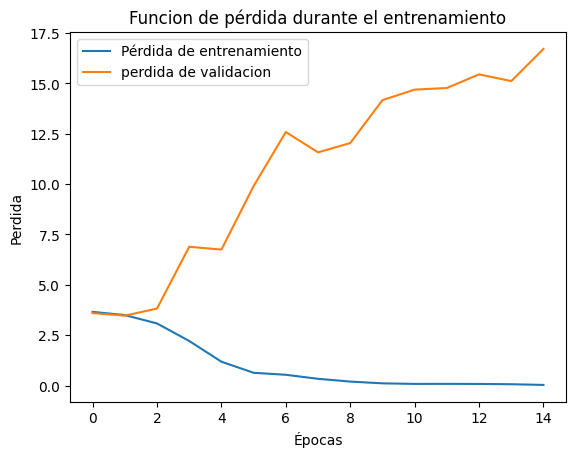

In [12]:
plt.plot(history.history['loss'], label='Pérdida de entrenamiento')
plt.plot(history.history['val_loss'], label='perdida de validacion')
plt.title('Funcion de pérdida durante el entrenamiento')
plt.xlabel('Épocas')
plt.ylabel('Perdida')
plt.legend()
plt.show()

In [13]:
#  Evaluación del modelo
print("\nEvaluación en el conjunto de prueba:")
loss, accuracy = model.evaluate(ds_test)
print(f"Precisión del modelo en la prueba: {accuracy:.4f}")


Evaluación en el conjunto de prueba:
115/115 ━━━━━━━━━━━━━━━━━━━━ 77s 669ms/step - accuracy: 0.0723 - loss: 16.4904
Precisión del modelo en la prueba: 0.0733
